### Advanced Regression Assignment : Surprise Housing

#### Problem Statement :
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price.

The company has collected a data set from the sale of houses in Australia.

#### The company wants to know:

 -- Which variables are significant in predicting the price of a house, and

 -- How well those variables describe the price of a house.
 
 Also, determine the optimal value of lambda for ridge and lasso regression.
 
 #### Business Goal
 
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

##### Following are the steps to be followed to perform this assignment

-- Reading, understanding,cleaning and visualising the data. 

-- Preparing the data for modelling (train-test split, rescaling etc) 

-- Building and Training the model -- Residual Analysis/Model Evaluation 

-- Predications and evaluation of the model

In [1]:
#importing the libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',150)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

### Custom Methods
Let's define all custom methods here for code conciseness.

In [2]:
# Let's define a method for checking missing value count per column.
def missingValueCount(data_frame, threshold):
    missing_value = data_frame.isnull().sum()
    return missing_value.loc[missing_value > threshold]

In [3]:

# Let's define a method for checking missing value percentage per column.
def missingValuePercentage(data_frame, threshold):
    missing_value = round(house_price_data.isnull().sum()/len(house_price_data.index),2).sort_values(ascending=False)
    return missing_value.loc[missing_value > threshold]


In [4]:
#Defining method to calculate age from year
def yearToAge(data_frame,col):
    new_cal = col + '_Old'
    data_frame[new_cal] = data_frame[col].max()-house_price_data[col]
    

In [5]:
#Defining method for imputing missing values 
def imputingMissingValue(data_frame,col,value):
    data_frame[col].fillna(value, inplace = True)

In [6]:
#Defining method for outliers  treatment
def dropOutliers(data_frame, numerical_columns):
    list = []
    for col in numerical_columns:
        Q1 = data_frame[col].quantile(.25)
        Q3 = data_frame[col].quantile(.99)
        IQR = Q3-Q1
        data_frame =  data_frame[(data_frame[col] >= (Q1-(1.5*IQR))) & (data_frame[col] <= (Q3+(1.5*IQR)))] 
    return data_frame

### Custom methods for Plotting and Visualization

In [7]:
# Defining method for plotting graphs based on numerical/continuous variables
def numericColAnalysis(data_frame, index,independent_variable ,target_variable):
    plt.figure(figsize = (20, 26))
    plt.figure(index)
    sns.jointplot(x = independent_variable, y = target_variable, data = data_frame[[independent_variable,target_variable]])

In [8]:
# Defining method for plotting graphs based on categorical variables
def categoricalColAnalysis(data_frame, index,independent_variable ,target_variable):
    plt.figure(index)
    variables = data_frame[[independent_variable]].nunique()
    plt.figure(figsize = (variables,variables/1.77))
    my_order = data_frame[[independent_variable,target_variable]].groupby(by = [independent_variable])[target_variable].median().sort_values(ascending=True)
    sns.boxplot(x = independent_variable, y = target_variable, data= data_frame[[independent_variable,target_variable]], order = my_order.index)

##  Reading and Understanding the DataData loading and cleaning

In [9]:
#Load data to pandas dataframe
house_price_data = pd.read_csv('train.csv')

In [10]:
#Firstly, let's have a look at the dimension of data
house_price_data.shape

(1460, 81)

In [11]:
#Let's have look on the metadata of the dataset
house_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
#Let's have a look at the first few rows of the Data
house_price_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
#Let's have a look at all the column names
house_price_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [14]:
#Let's check number of missing value per column.
missingValueCount(house_price_data, 0)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [15]:
#Let's check percentage of missing value per column.
missingValuePercentage(house_price_data, 0)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

Here I'm considering 10% as my threshold and dropping the column having more then the threshold

In [16]:
missing_data = missingValuePercentage(house_price_data, 0.10)
missing_data

PoolQC         1.00
MiscFeature    0.96
Alley          0.94
Fence          0.81
FireplaceQu    0.47
LotFrontage    0.18
dtype: float64

In [17]:
house_price_data = house_price_data.drop(list(missing_data.index),axis='columns')

In [18]:
#Checking the columns where the missing values less than or equal to 10%
missingValuePercentage(house_price_data, 0)

GarageType      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
GarageCond      0.06
BsmtFinType1    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType2    0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

In [19]:
#Let's have a look on first few data after droping missing values
house_price_data.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


Before proceeding ahaed, we will try to convert the Year columns into the age where we are going to fill these columns with number, And max year for all these columns come out to be 2010. For example, suppose the YrSold=2000 , Then YrSold_Old = 2010-2000 = 10

In [20]:
#Converting the year column into age
yearToAge(house_price_data,'YearBuilt')
yearToAge(house_price_data,'YearRemodAdd')
yearToAge(house_price_data,'GarageYrBlt')
yearToAge(house_price_data,'YrSold')

In [21]:
#Let's have a look on data after converting into age
house_price_data[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
0,2003,2003,2003.0,2008,7,7,7.0,2
1,1976,1976,1976.0,2007,34,34,34.0,3
2,2001,2002,2001.0,2008,9,8,9.0,2
3,1915,1970,1998.0,2006,95,40,12.0,4
4,2000,2000,2000.0,2008,10,10,10.0,2


In [22]:
#Let's drop the actual Year columns
house_price_data = house_price_data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'], axis = 'columns')

### Imputing missing value
Some columns have values as NA, But they are usefull in our analysis, So here we try to impute those values with similar class/category.

In [23]:
imputingMissingValue(house_price_data,'MasVnrType', 'None')
imputingMissingValue(house_price_data,'MasVnrArea' ,house_price_data.MasVnrArea.mean())
imputingMissingValue(house_price_data,'BsmtQual', 'TA')
imputingMissingValue(house_price_data,'BsmtCond', 'TA')
imputingMissingValue(house_price_data,'BsmtExposure', 'No')
imputingMissingValue(house_price_data,'BsmtFinType1', 'Unf')
imputingMissingValue(house_price_data,'BsmtFinType2', 'Unf')
imputingMissingValue(house_price_data,'GarageType', 'Attchd')
imputingMissingValue(house_price_data,'GarageYrBlt_Old', -1)
imputingMissingValue(house_price_data,'GarageFinish', 'Unf')
imputingMissingValue(house_price_data,'GarageQual', 'TA')
imputingMissingValue(house_price_data,'GarageCond', 'TA')

As per the analysis 'Street' & 'Utilities' is explaining the lowest varience hence dropping these columns.

In [24]:
house_price_data['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [25]:
house_price_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [26]:
house_price_data = house_price_data.drop(['Utilities','Street'], axis = 'columns')

'Id' column is also of no use for our analysis hence dropping the column

In [27]:
house_price_data = house_price_data.drop('Id', axis = 'columns')

In [28]:
#Checking the columns where the missing values
missingValuePercentage(house_price_data, 0)

Series([], dtype: float64)

Now, We have no null values in the dataset

In [29]:
#Get all numerical Columns
numerical_columns = house_price_data.select_dtypes(include = np.number).columns.tolist()
numerical_columns.remove('SalePrice')

<Figure size 432x288 with 0 Axes>

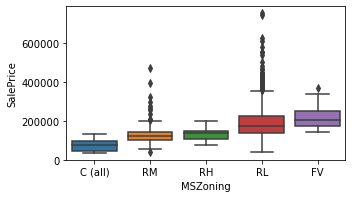

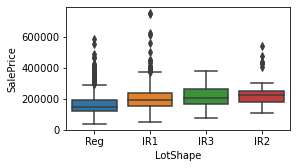

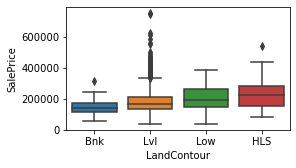

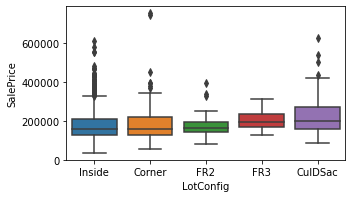

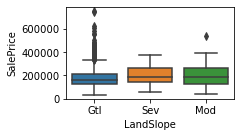

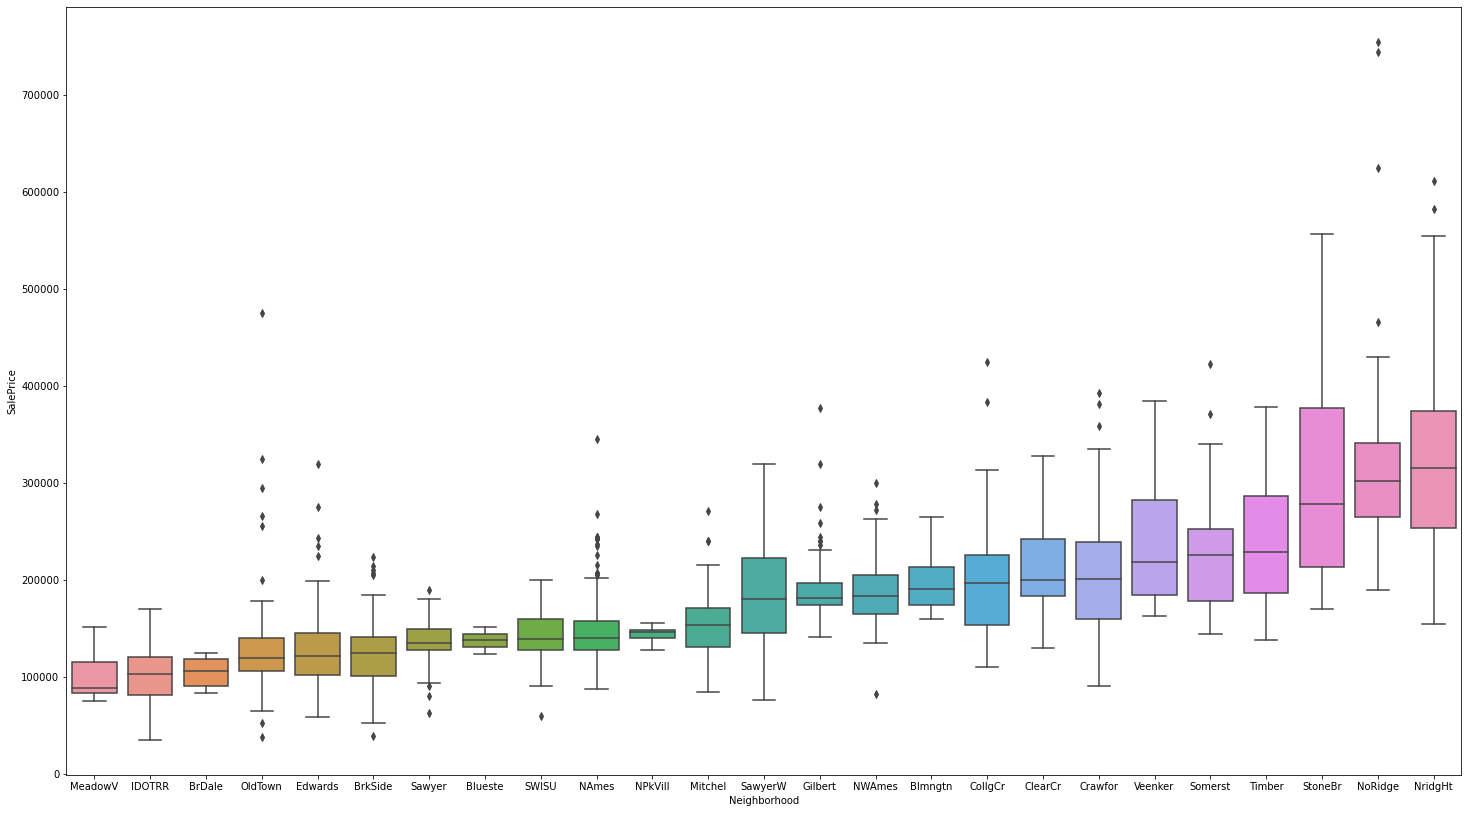

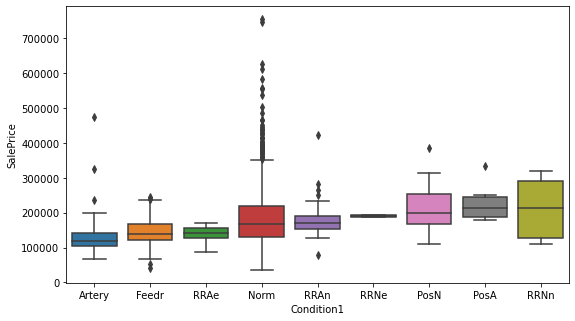

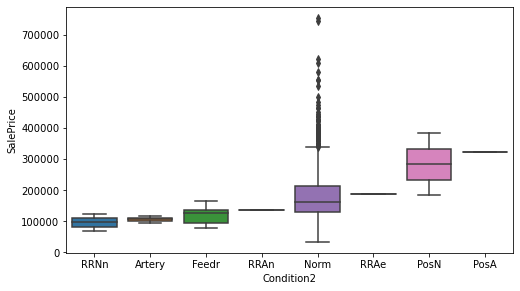

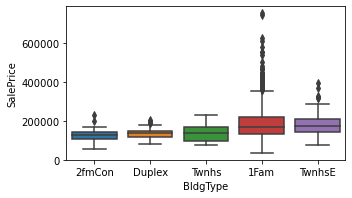

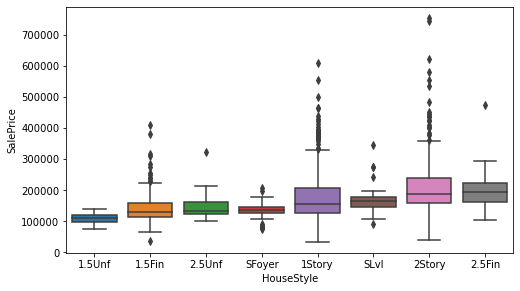

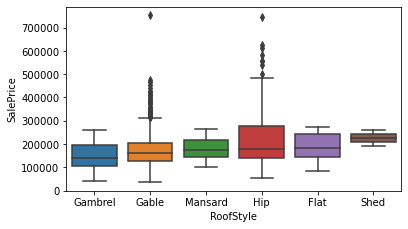

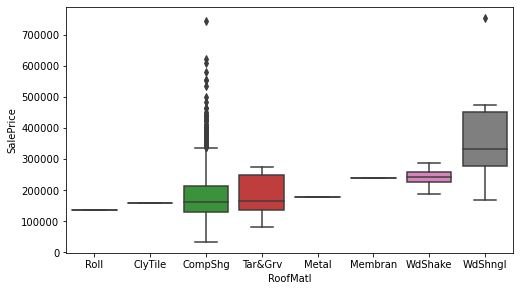

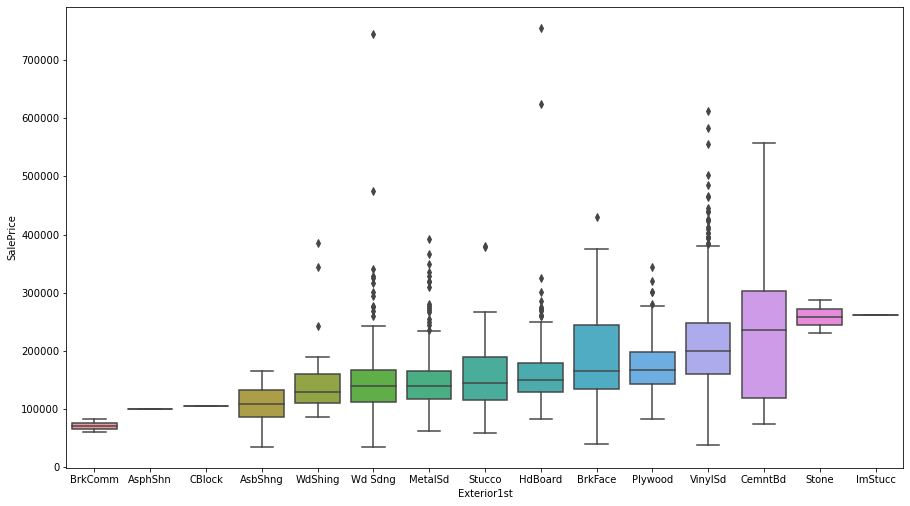

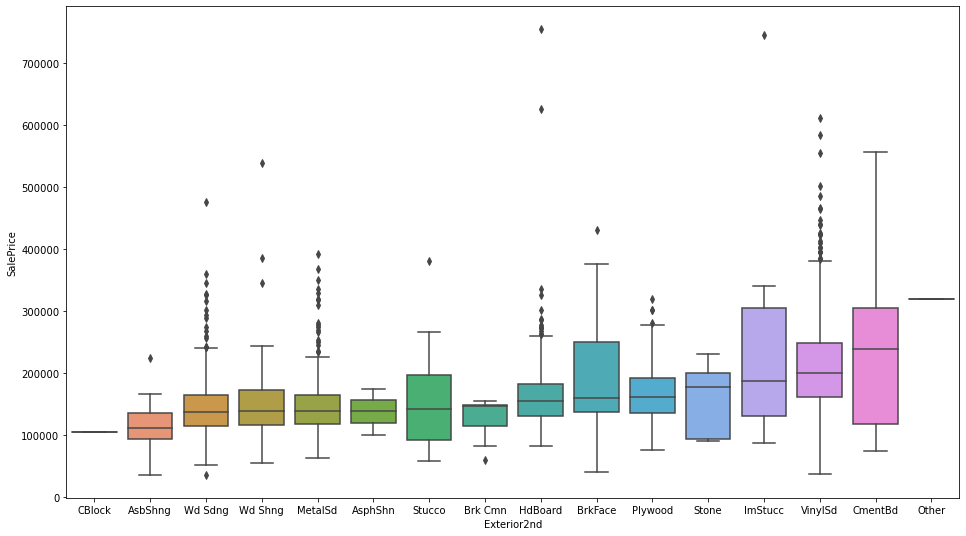

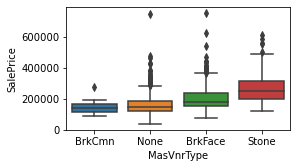

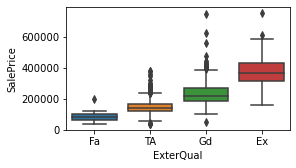

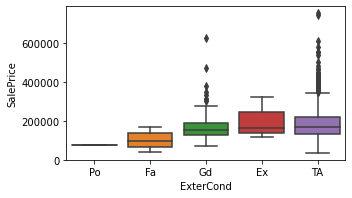

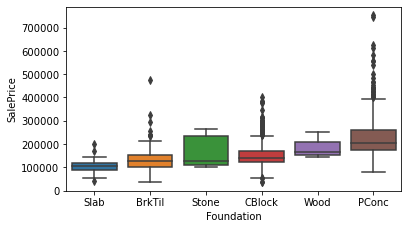

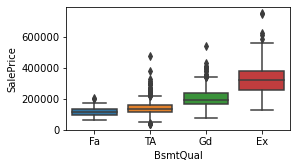

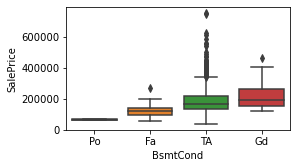

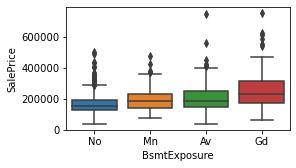

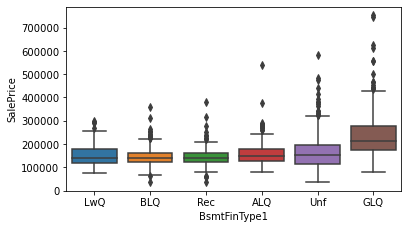

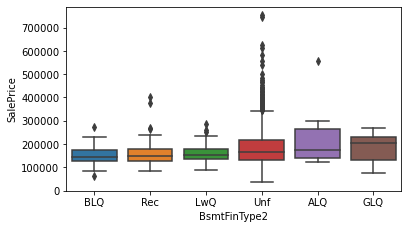

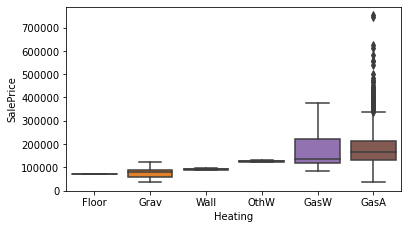

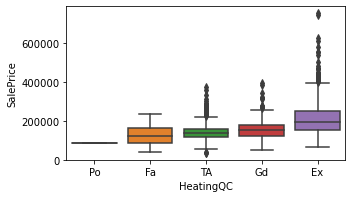

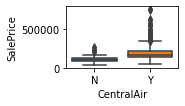

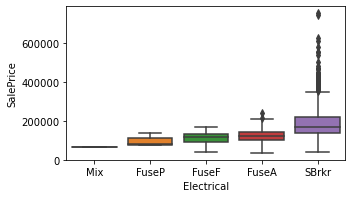

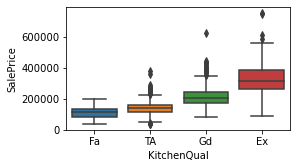

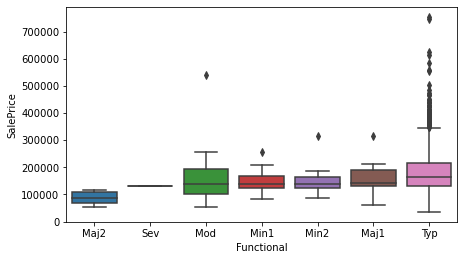

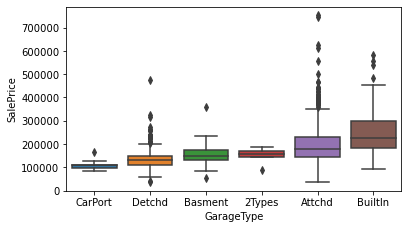

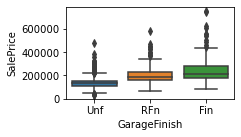

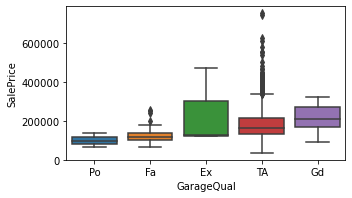

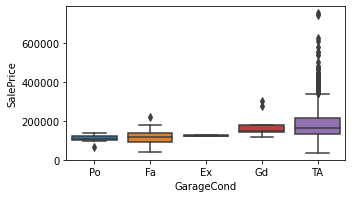

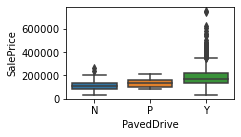

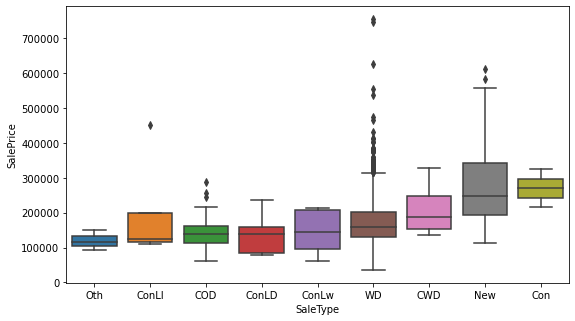

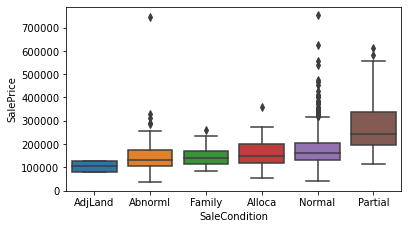

In [30]:
#Ploting the graph for all categorical variables
categorical_columns = house_price_data.select_dtypes(include = np.object).columns.tolist()
for index, col in enumerate(categorical_columns):
    categoricalColAnalysis(house_price_data, index, col, 'SalePrice')

Let’s prepare a heat map and take a look at the correlations between the variables.

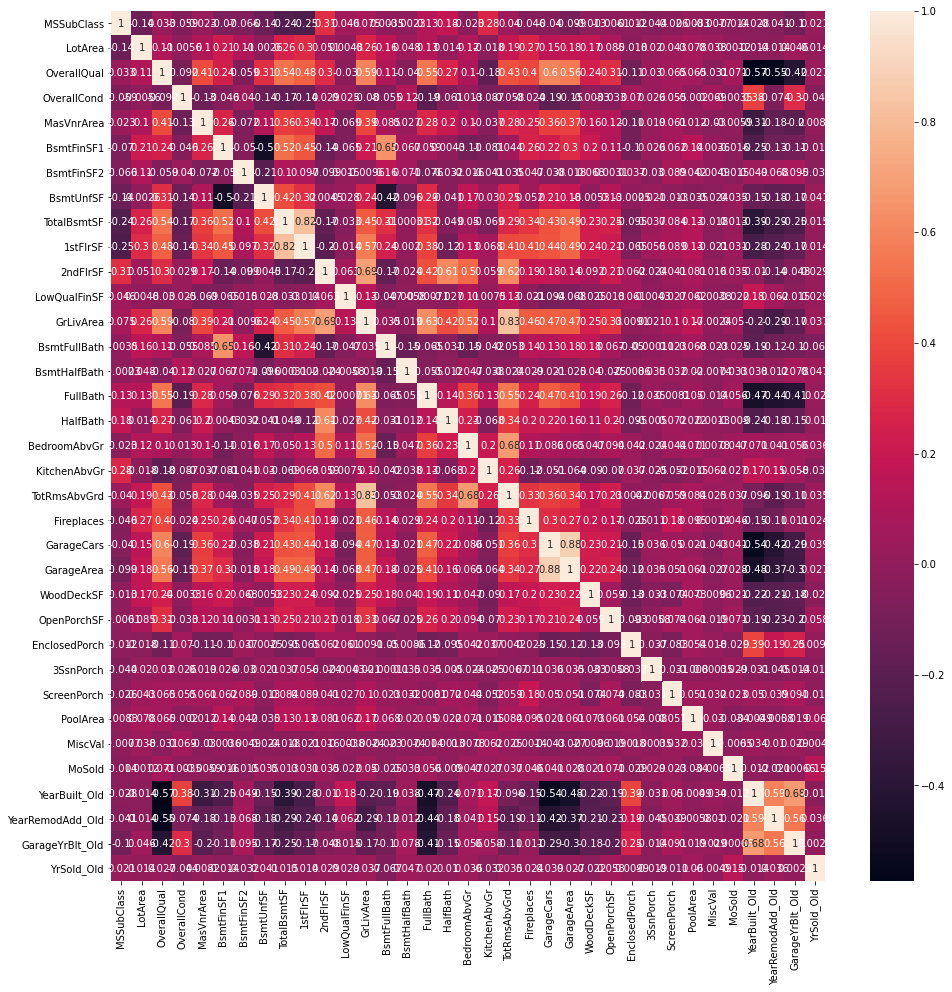

In [31]:
plt.figure(figsize=(16,16))
sns.heatmap(house_price_data[numerical_columns].corr(), annot = True)
plt.show()

#  Preparing tha Data for Modelling

In [32]:
#Let's chcking data_frame shape
house_price_data.shape

(1460, 72)

Let's do the outliers treatment where i am taking the lower and upper quantile as 0.25 & 0.99 respectively

In [33]:
numerical_columns = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
house_price_data = dropOutliers(house_price_data, numerical_columns)

In [34]:
#Let's have a look on first few columns
house_price_data[categorical_columns].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


Let's check for the below columns, here we can clearly see that these are having some kind of order and hence we can say these are ordinal in nature.

In [35]:
ordinal_columns = ['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']
house_price_data[ordinal_columns].head()


,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


In [36]:
# Let's convert categorical variable to numeric. 
house_price_data[ordinal_columns[0]] = house_price_data[ordinal_columns[0]].map({'Gtl':0,'Mod':1,'Sev':2})
house_price_data[ordinal_columns[1]] = house_price_data[ordinal_columns[1]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price_data[ordinal_columns[2]] = house_price_data[ordinal_columns[2]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price_data[ordinal_columns[3]] = house_price_data[ordinal_columns[3]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price_data[ordinal_columns[4]] = house_price_data[ordinal_columns[4]].map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price_data[ordinal_columns[5]] = house_price_data[ordinal_columns[5]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price_data[ordinal_columns[6]] = house_price_data[ordinal_columns[6]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price_data[ordinal_columns[7]] = house_price_data[ordinal_columns[7]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price_data[ordinal_columns[8]] = house_price_data[ordinal_columns[8]].map({'N':0,'Y':1})
house_price_data[ordinal_columns[9]] = house_price_data[ordinal_columns[9]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price_data[ordinal_columns[10]] = house_price_data[ordinal_columns[10]].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price_data[ordinal_columns[11]] = house_price_data[ordinal_columns[11]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price_data[ordinal_columns[12]] = house_price_data[ordinal_columns[12]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price_data[ordinal_columns[13]] = house_price_data[ordinal_columns[13]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price_data[ordinal_columns[14]] = house_price_data[ordinal_columns[14]].map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [37]:
house_price_data[ordinal_columns].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


__Creating and joining dummy variables with the actual dataset__

In [38]:
dummy_col = pd.get_dummies(house_price_data[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

house_price_data = pd.concat([house_price_data,dummy_col],axis='columns')

house_price_data = house_price_data.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

__Let's check the distribution of our target variable before scaling and Splitting__

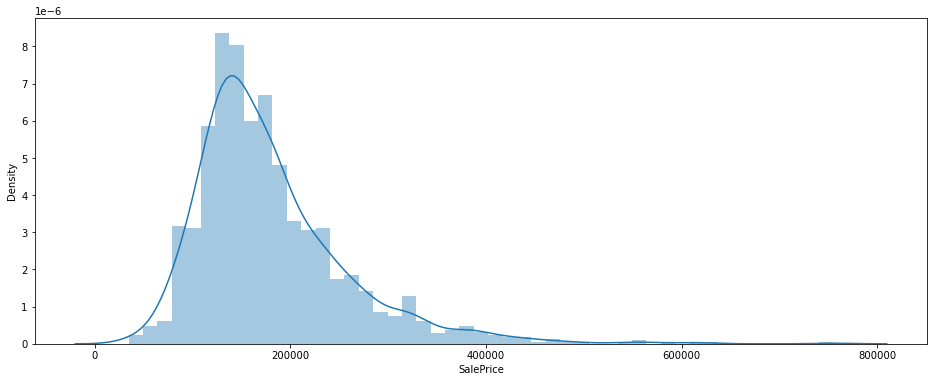

In [39]:
# Plotting the graph
plt.figure(figsize=(16,6))
sns.distplot(house_price_data.SalePrice)
plt.show()

__Spliting the dataset into train and test for modeling__

In [40]:
df_train,df_test = train_test_split(house_price_data,train_size=0.7,test_size=0.3,random_state=50)

__Scaling the train dataset__

In [41]:
numerical_columns = house_price_data.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

__Lets check the distribution again after scaling of test and train__

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

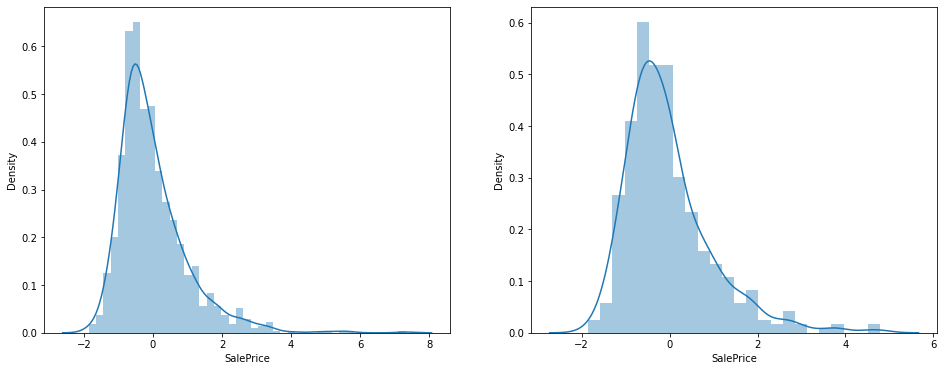

In [42]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

## Training the Model

Now that we have prepared the data and are done with the test-train split. Let's divide into X and y sets for the model building.

In [43]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [44]:
y_test = df_test.pop('SalePrice')
X_test = df_test

##Now using RFE lets try to to find the optimal number of feature

In [45]:
len(X_train.columns)

193

In [46]:
X_train.columns.tolist()

['MSSubClass',
 'LotArea',
 'LotShape',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YearBuilt_Old',
 'YearRemodAdd_Old',
 'GarageYrBlt_Old',
 'YrSold_Old',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborho

In [47]:
# Running RFE with the output number of the variable equal to 70
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

NameError: name 'RFE' is not defined

In [ ]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [ ]:
#Check RFE selected variables
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)
rfe_sel_columns

__Lets filter the train and test set for the RFE selected columns__

In [ ]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

## Lets try first with the Lasso regression model

In [ ]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

__As we can see the above alpha value is near to optimal for lasso as we can see in the train and test score is quite similar.
Now let check whether we can improve our model by using GridSearchCV for optimal value of alpha__

In [ ]:
# Using KFold for model valodation
folds = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True,
                        n_jobs = -1
                       )

model_cv.fit(X_train,y_train)

In [ ]:
# Let have a look on the summery of test and train score based on alpha
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

In [ ]:
# Plot showing comparision of test and train score
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [ ]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

In [ ]:
# After performing grid search we found the same alpha that ue use before
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [ ]:
# Significant variables which predict price of house when used lasso
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

## Now lets use the ridge regression

In [ ]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

__As we can see the above alpha value is not optimal for ridge there are sign of overfitting the clear difference we can see in the train and test score
Now lets try to improve our model with the optimal value of alpha using GridSearchCV__

In [ ]:
folds  = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True)
                        

model_cv.fit(X_train,y_train)

In [ ]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

In [ ]:
# Plot showing comparision of test and train score
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

__On the basis of above graph lets create the model__


In [ ]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

In [ ]:
# After performing grid search we found the optimal alpha to be 20, so let's predict the test and train scores.
ridge = Ridge(alpha = 20.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

In [ ]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [ ]:
# Significant variables which predict price of house when used ridge
ridge_coef.sort_values(by = 'Coef',ascending = False).head(10)

# Final Model

In [ ]:
# We have used lasso for building the modle as we got the optimal value of alpha.
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true = y_train,y_pred = y_train_pred))
print(r2_score(y_true = y_test,y_pred = y_test_pred))

# Conclusion

__These variables are significant in predicting the price of a house :__

- BsmtFinSF2 : Type 2 finished square feet.
- LotShape : General shape of property.
- ExterCond : Evaluates the present condition of the material on the exterior.
- GarageCars : Size of garage in car capacity.
- Neighborhood_Gilbert : Physical locations within Ames city limits(Gilbert).
- BsmtFinSF1 : Type 1 finished square feet.
- OverallQual : Rates the overall material and finish of the house.
- BsmtExposure : Refers to walkout or garden level walls.
- CentralAir : Central air conditioning.
- OverallCond : Rates the overall condition of the house.

__The optimal value of lambda for ridge and lasso regression are :__

Best alpha value for Lasso : 0.001

Best alpha value for Ridge : 20.0